# Herbarium 2021: Half-Earth Challenge - FGVC8 - Exploratory Data Analysis

Quick Exploratory Data Analysis for [Herbarium 2021: Half-Earth Challenge - FGVC8](https://www.kaggle.com/c/herbarium-2021-fgvc8) challenge    

The Herbarium 2021: Half-Earth Challenge is to identify vascular plant specimens provided by the [New York Botanical Garden (NY)](https://www.nybg.org/), [Bishop Museum (BPBM)](https://www.bishopmuseum.org/), [Naturalis Biodiversity Center (NL)](https://www.naturalis.nl/en), [Queensland Herbarium (BRI)](https://www.qld.gov.au/environment/plants-animals/plants/herbarium), and [Auckland War Memorial Museum (AK)](https://www.aucklandmuseum.com/).

*The Herbarium 2021: Half-Earth Challenge* dataset includes more than 2.5M images representing nearly 65,000 species from the Americas and Oceania that have been aligned to a standardized plant list ([LCVP v1.0.2](https://www.nature.com/articles/s41597-020-00702-z)).

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25558/logos/header.png)

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:brown; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [Overview](#1)
* [Data Visualization](#2)
    
    
* [Competition Metric](#100)
* [Sample Submission](#101)
    
    
* [Modeling](#200)
* [Ensembling](#201)

<a id="1"></a>
<h2 style='background:brown; border:0; color:white'><center>Overview<center><h2>

The training and test set contain images of herbarium specimens from nearly 65,000 species of vascular plants. Each image contains exactly one specimen. The text labels on the specimen images have been blurred to remove category information in the image.

The data has been approximately split 80%/20% for training/test. Each category has at least 1 instance in both the training and test datasets. Note that the test set distribution is slightly different from the training set distribution. The training set contains species with hundreds of examples, but the test set has the number of examples per species capped at a maximum of 10.

In [1]:
import os
import json
import collections

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

### Read the metadata file

In [2]:
PATH_BASE = "../input/herbarium-2021-fgvc8/"
PATH_TRAIN = os.path.join(PATH_BASE, "train/")
PATH_TRAIN_META = os.path.join(PATH_TRAIN, "metadata.json")


with open(PATH_TRAIN_META) as json_file:
    metadata = json.load(json_file)

### First level elements

In [3]:
metadata.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])

### Check the number of images and their annotations

In [4]:
len(metadata["annotations"]), len(metadata["images"])

(2257759, 2257759)

### Check first samples from each key

In [5]:
print(metadata["annotations"][0])
print(metadata["images"][0])
print(metadata["categories"][0])
print(metadata["licenses"][0])
print(metadata["institutions"][0])

{'category_id': 60492, 'id': 1814367, 'image_id': 1814367, 'institution_id': 0}
{'file_name': 'images/604/92/1814367.jpg', 'height': 1000, 'id': 1814367, 'license': 0, 'width': 678}
{'family': 'Orchidaceae', 'order': 'Asparagales', 'name': 'Aa calceata (Rchb.f.) Schltr.', 'id': 0}
{'id': 0, 'name': 'Public Domain Dedication', 'url': 'http://creativecommons.org/publicdomain/zero/1.0/'}
{'id': 0, 'name': 'New York Botanical Garden'}


### Calculate the total number of classes

In [6]:
len(set([annotation["category_id"] for annotation in metadata["annotations"]]))

64500

### Create DataFrame with main information

In [7]:
ids = []
categories = []
paths = []

for annotation, image in zip(metadata["annotations"], metadata["images"]):
    assert annotation["image_id"] == image["id"]
    ids.append(image["id"])
    categories.append(annotation["category_id"])
    paths.append(image["file_name"])
        
df_meta = pd.DataFrame({"id": ids, "category": categories, "path": paths})

In [8]:
df_meta

,id,category,path
0,1814367,60492,images/604/92/1814367.jpg
1,1308257,10824,images/108/24/1308257.jpg
2,1270453,33076,images/330/76/1270453.jpg
3,1123834,24799,images/247/99/1123834.jpg
4,1042410,17018,images/170/18/1042410.jpg
...,...,...,...
2257754,812040,51130,images/511/30/812040.jpg
2257755,701754,35499,images/354/99/701754.jpg
2257756,662006,56547,images/565/47/662006.jpg
2257757,234505,57499,images/574/99/234505.jpg


### Classes distribution

In [9]:
df_meta["category"].value_counts()

42811    3309
25229    2142
48372    2038
42843    1656
22344    1575
         ... 
62525       2
11297       2
58424       2
39154       2
2047        2
Name: category, Length: 64500, dtype: int64

### Find name and family of the classes by their ids

In [10]:
d_categories = {category["id"]: category["name"] for category in metadata["categories"]}
d_families = {category["id"]: category["family"] for category in metadata["categories"]}
d_orders = {category["id"]: category["order"] for category in metadata["categories"]}

df_meta["category_name"] = df_meta["category"].map(d_categories)
df_meta["family_name"] = df_meta["category"].map(d_families)
df_meta["order_name"] = df_meta["category"].map(d_orders)
df_meta

,id,category,path,category_name,family_name,order_name
0,1814367,60492,images/604/92/1814367.jpg,Thysanocarpus curvipes Hook.,Brassicaceae,Brassicales
1,1308257,10824,images/108/24/1308257.jpg,Cassia grandis L.f.,Fabaceae,Fabales
2,1270453,33076,images/330/76/1270453.jpg,Leptospermum whitei Cheel,Myrtaceae,Myrtales
3,1123834,24799,images/247/99/1123834.jpg,Fallopia scandens (L.) Holub,Polygonaceae,Caryophyllales
4,1042410,17018,images/170/18/1042410.jpg,Cyperus dentatus Torr.,Cyperaceae,Poales
...,...,...,...,...,...,...
2257754,812040,51130,images/511/30/812040.jpg,Quercus rubra L.,Fagaceae,Fagales
2257755,701754,35499,images/354/99/701754.jpg,Malus fusca (Raf.) C.K.Schneid.,Rosaceae,Rosales
2257756,662006,56547,images/565/47/662006.jpg,Solanum elaeagnifolium Cav.,Solanaceae,Solanales
2257757,234505,57499,images/574/99/234505.jpg,Sphyrospermum buxifolium Poepp. & Endl.,Ericaceae,Ericales


<a id="2"></a>
<h2 style='background:brown; border:0; color:white'><center>Data Visualization<center><h2>

In [11]:
def visualize_train_batch(paths, categories, families, orders):
    plt.figure(figsize=(16, 16))
    
    for ind, info in enumerate(zip(paths, categories, families, orders)):
        path, category, family, order = info
        
        plt.subplot(2, 3, ind + 1)
        
        image = cv2.imread(os.path.join(PATH_TRAIN, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        
        plt.title(
            f"FAMILY: {family} ORDER: {order}\n{category}", 
            fontsize=10,
        )
        plt.axis("off")
    
    plt.show()

In [12]:
def visualize_by_id(df, _id=None):
    tmp = df.sample(6)
    if _id is not None:
        tmp = df[df["category"] == _id].sample(6)

    visualize_train_batch(
        tmp["path"].tolist(), 
        tmp["category_name"].tolist(),
        tmp["family_name"].tolist(),
        tmp["order_name"].tolist(),
    )

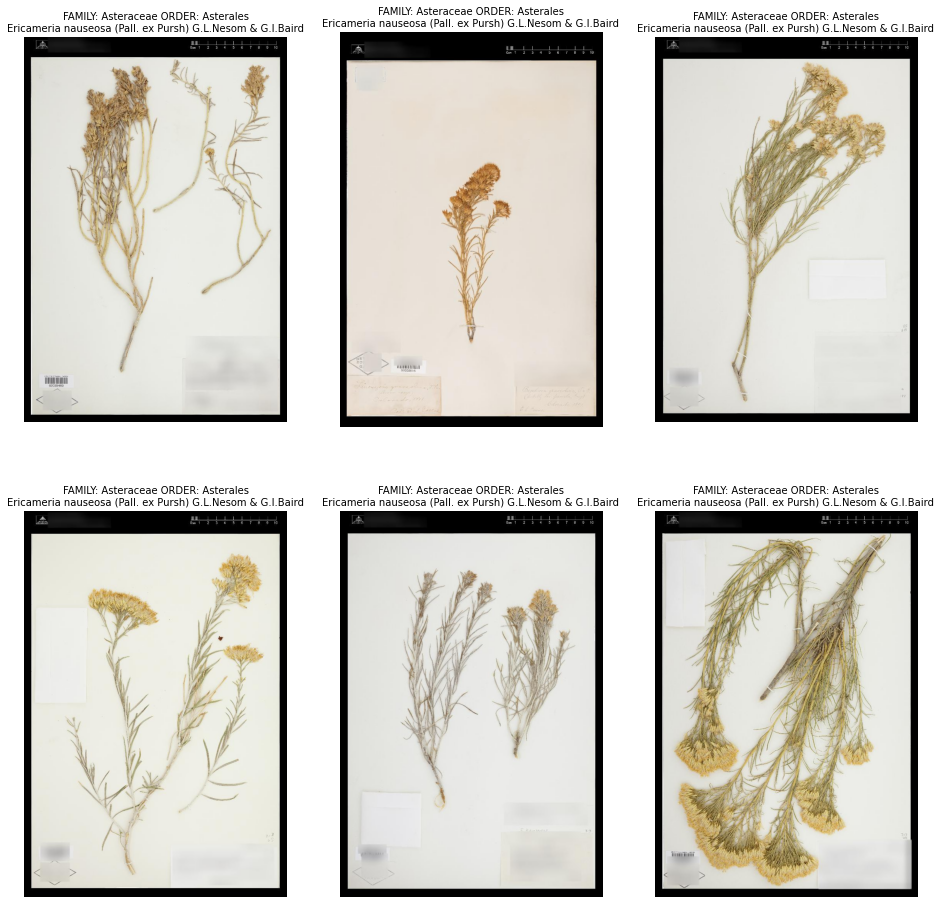

In [13]:
visualize_by_id(df_meta, 22344)

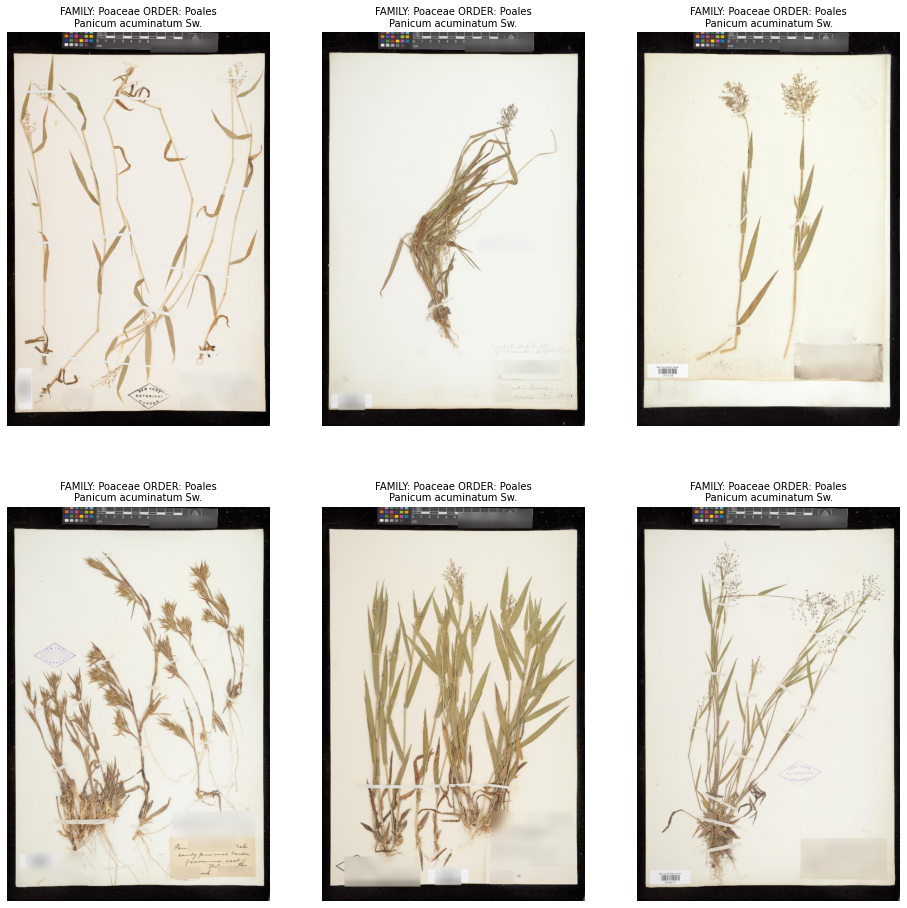

In [14]:
visualize_by_id(df_meta, 42811)

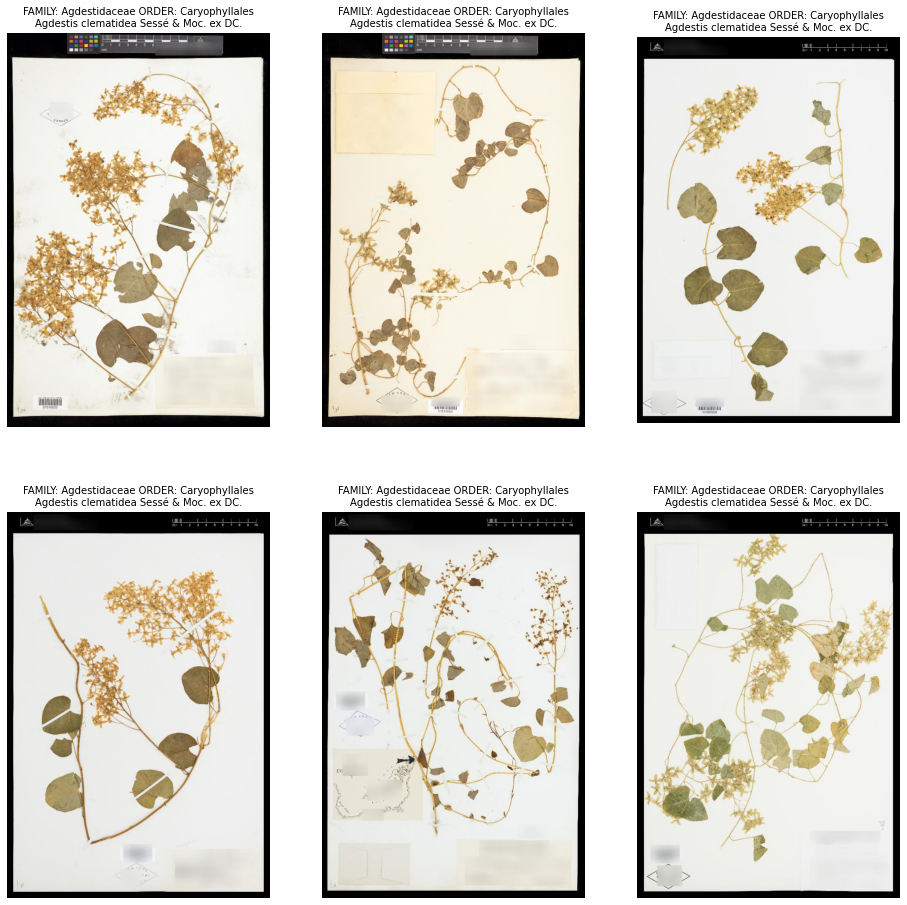

In [15]:
visualize_by_id(df_meta, 1719)

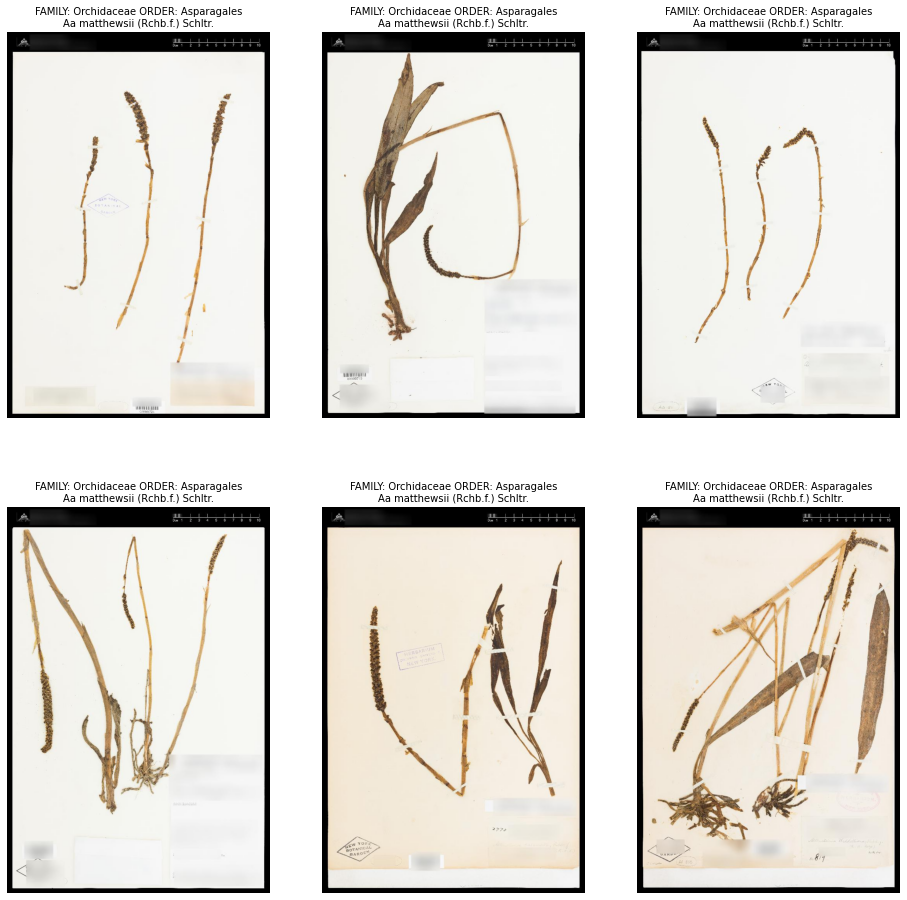

In [16]:
visualize_by_id(df_meta, 1)

### Random samples

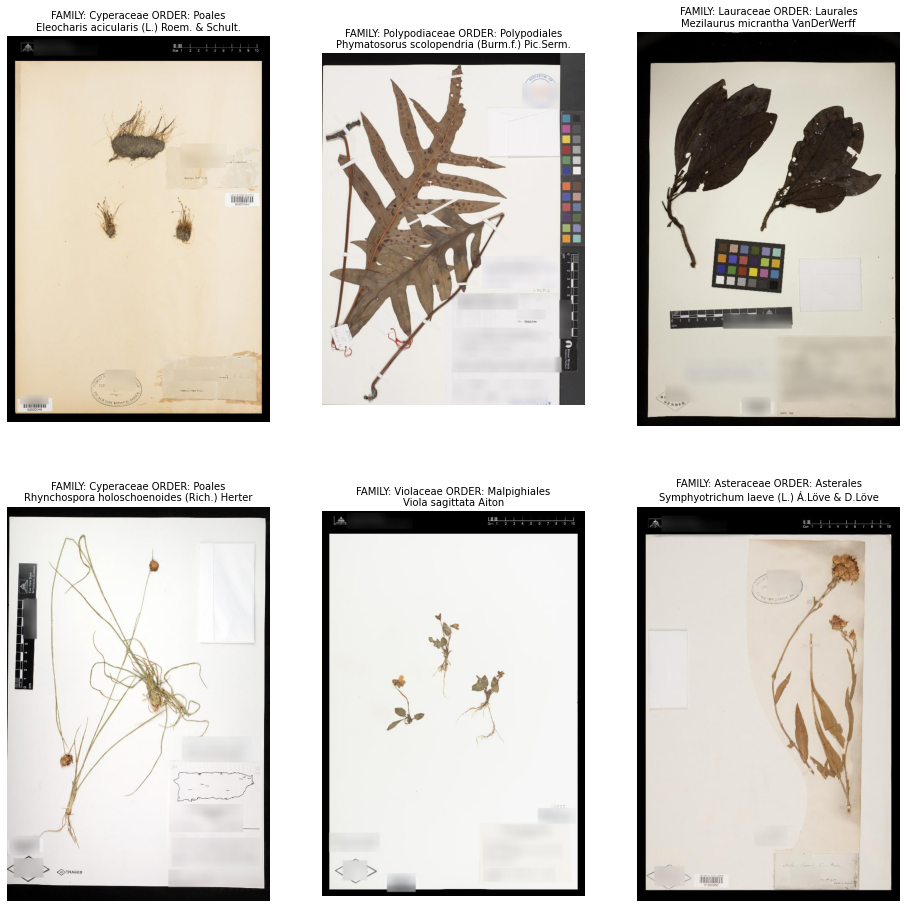

In [17]:
visualize_by_id(df_meta)

<a id="100"></a>
<h2 style='background:brown; border:0; color:white'><center>Competition Metric<center><h2>

Submissions are evaluated using the [macro F1 score](#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

$$F_1 = 2\frac{precision \cdot recall}{precision+recall}$$

where:

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

In "macro" F1 a separate F1 score is calculated for each species value and then averaged.

<a id="101"></a>
<h2 style='background:brown; border:0; color:white'><center>Sample Submission<center><h2>

In [18]:
df_submission = pd.read_csv(
    "../input/herbarium-2021-fgvc8/sample_submission.csv",
    index_col=0,
)

### One of the most frequently class from train data

In [19]:
df_submission["Predicted"] = 25229

In [20]:
df_submission.to_csv("submission.csv")

In [21]:
pd.read_csv("submission.csv", index_col=0)

,Predicted
Id,
0,25229
1,25229
2,25229
3,25229
4,25229
...,...
243015,25229
243016,25229
243017,25229


<a id="200"></a>
<h2 style='background:brown; border:0; color:white'><center>Modeling<center><h2>

### The idea: Create for each category abstract vector from some model (MobileNetV2) and find nearest vector for each train sample

In [22]:
FULL_PIPELINE = False

### Import libraries

In [23]:
import os
import random

import numpy as np
from numpy import save, load
import pandas as pd
import cv2
import albumentations as A
from albumentations import pytorch as ATorch
import torch
from torch.utils import data as torch_data
from torch import nn as torch_nn
from torch.nn import functional as torch_functional
import torchvision
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances

### Define the model

You can use any of the pretrained models, for example:
- [PYTORCH HUB FOR RESEARCHERS](https://pytorch.org/hub/research-models)
- [TORCHVISION.MODELS](https://pytorch.org/vision/stable/models.html)

In [24]:
class MobileNetV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        tmp_net = torch.hub.load(
            "pytorch/vision:v0.6.0", "mobilenet_v2", pretrained=True
        )
        self.net = torch_nn.Sequential(*(list(tmp_net.children())[:-1]))

    def forward(self, x):
        return self.net(x)

### Define your dataset class for getting image samples

In [25]:
class DataRetriever(torch_data.Dataset):
    def __init__(
        self, 
        paths, 
        categories=None,
        transforms=None,
        base_path=PATH_TRAIN
    ):
        self.paths = paths
        self.categories = categories
        self.transforms = transforms
        self.base_path = base_path
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.base_path, self.paths[index]))
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
        
        if self.categories is None:
            return img
        
        y = self.categories[index] 
        return img, y
    
    
def get_transforms():
    return A.Compose(
        [
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                p=1.0
            ),
            ATorch.transforms.ToTensorV2(p=1.0),
        ], 
        p=1.0
    )

### Let's take for each category (target) all images from the train set and after processing average their vectors


In [26]:
df_train = df_meta[["category", "path"]].sort_values(by="category")

df_train

,category,path
686068,0,images/000/00/1360648.jpg
437023,0,images/000/00/1433074.jpg
2168929,0,images/000/00/1703060.jpg
2035057,1,images/000/01/230965.jpg
67677,1,images/000/01/404873.jpg
...,...,...
2059480,64499,images/644/99/1764488.jpg
244511,64499,images/644/99/1936388.jpg
1140489,64499,images/644/99/1732175.jpg
2081989,64499,images/644/99/1427426.jpg


In [27]:
tmp_path = df_train["path"].tolist()
tmp_category = df_train["category"].tolist()
# If FULL_PIPELINE is False we use small subset of data
if not FULL_PIPELINE:
    tmp_path = tmp_path[:256 * 8]
    tmp_category = tmp_category[:256 * 8]

train_data_retriever = DataRetriever(
    tmp_path,
    tmp_category,
    transforms=get_transforms(),
)

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=256,
    shuffle=False,
    num_workers=8,
)

### Initialize the model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MobileNetV2()
model.to(device)
model.eval();

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Save output vectors from the model and average by category

In [29]:
category_counts = collections.Counter(df_train["category"].tolist())

In [30]:
final_vectors = np.zeros((len(category_counts), 1280))

with torch.no_grad():
    for batch in tqdm(train_loader):
        X, y = batch
        vectors = model(X.to(device)).mean(axis=(2, 3))
        
        _y = y.numpy().tolist()
        for ind in range(len(_y)):
            final_vectors[_y[ind]] += vectors[ind].cpu().numpy().copy() / category_counts[_y[ind]]

100%|██████████| 8/8 [00:23<00:00,  3.00s/it]


### Save and load category vectors (you can pretrain them)

In [31]:
save("average_vectors.npy", final_vectors)

In [32]:
final_vectors = load("average_vectors.npy")

### Get test paths

In [33]:
PATH_TEST = os.path.join(PATH_BASE, "test/")
PATH_TEST_META = os.path.join(PATH_TEST, "metadata.json")


with open(PATH_TEST_META) as json_file:
    metadata = json.load(json_file)

    
id2path = {
    img["id"]: img["file_name"] for img in metadata["images"]
}

In [34]:
df_submission = pd.read_csv(
    "../input/herbarium-2021-fgvc8/sample_submission.csv",
    index_col=0,
)

df_submission["Id"] = df_submission.index
df_submission["Path"] = df_submission["Id"].map(lambda x: id2path[x])

### Create test data loader

In [35]:
tmp_path = df_submission["Path"].tolist()
# If FULL_PIPELINE is False we use small subset of data
if not FULL_PIPELINE:
    tmp_path = tmp_path[:256 * 2]

test_data_retriever = DataRetriever(
    tmp_path,
    transforms=get_transforms(),
    base_path=PATH_TEST,
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=256,
    shuffle=False,
    num_workers=8,
)

### Get test output vectors and find the nearest train vector (by euclidean distance) and take its category

In [36]:
res = []

with torch.no_grad():
    for ind, X in enumerate(tqdm(test_loader)):
        vectors = model(X.to(device)).mean(axis=(2, 3))
        tmp = euclidean_distances(vectors.cpu().numpy(), final_vectors)
        res.extend(list(tmp.argmin(axis=1)))

100%|██████████| 2/2 [01:15<00:00, 37.77s/it]


### Save results to submission file

In [37]:
df_submission.iloc[:len(res), 0] = res

df_submission[["Predicted"]].to_csv("submission.csv")

pd.read_csv("submission.csv", index_col=0)

,Predicted
Id,
0,61
1,47
2,87
3,36
4,63
...,...
243015,0
243016,0
243017,0


### I prepared processed by the algorithm described above submission file for all data, you can use it for fast submission

In [38]:
PATH_PREPARED_SUBMISSION = "../input/herbarium-2021-submissions/submission-mobilenetv2-mean.csv"

prepared_submission = pd.read_csv(PATH_PREPARED_SUBMISSION, index_col=0)
prepared_submission.to_csv("prepared_submission.csv")

pd.read_csv("prepared_submission.csv", index_col=0)

,Predicted
Id,
0,45270
1,51945
2,59808
3,58594
4,17009
...,...
243015,9186
243016,20314
243017,10056


<a id="201"></a>
<h2 style='background:brown; border:0; color:white'><center>Ensembling<center><h2>

In [39]:
PATH_RESNET18 = "../input/herbarium-2021-submissions/submission-resnet18-model.csv"

resnet18_submission = pd.read_csv(PATH_RESNET18, index_col=0)
resnet18_submission.to_csv("resnet18_submission.csv")

pd.read_csv("resnet18_submission.csv", index_col=0)

,Predicted
Id,
0,45246
1,47386
2,35602
3,38896
4,4731
...,...
243015,36536
243016,49262
243017,10005


In [40]:
PATH_RESNET50 = "../input/herbarium-2021-submissions/submission-resnet50-model.csv"

resnet50_submission = pd.read_csv(PATH_RESNET50, index_col=0)
resnet50_submission.to_csv("resnet50_submission.csv")

pd.read_csv("resnet50_submission.csv", index_col=0)

,Predicted
Id,
0,45291
1,63655
2,35602
3,38896
4,2258
...,...
243015,9182
243016,29597
243017,9994


## Work In Progress

Next steps:
- Add ensemble of different models

![](https://i.postimg.cc/htpxH99f/Herbarium2021.png)

The images are provided by the [New York Botanical Garden](https://www.nybg.org/), [Bishop Museum](https://www.bishopmuseum.org/), [Naturalis Biodiversity Center](https://www.naturalis.nl/en), [Queensland Herbarium](https://www.qld.gov.au/environment/plants-animals/plants/herbarium), and [Auckland War Memorial Museum](https://www.aucklandmuseum.com/).

![](https://i.postimg.cc/fbSLBX54/Logos.png)